In [164]:
import pathlib
import re
import pandas
import matplotlib
import numpy

zip_file=pathlib.Path('..','input','stock_price_data_files.zip').absolute()
print(f"Reading input from {zip_file}")

Reading input from C:\Users\drago\PycharmProjects\scientificProject\notebooks\..\input\stock_price_data_files.zip


In [165]:
from zipfile import ZipFile
all_input_files= {}
with ZipFile(zip_file,'r') as zf:
    for filename in [it.filename for it in zf.filelist if re.match(r'\w+\/\w+\.csv',it.filename)]:
        with zf.open(filename)as f:
            all_input_files[filename]=pandas.read_csv(f)
pandas.DataFrame([{'file':k,'lines':len(v)} for (k,v) in all_input_files.items()])

,file,lines
0,LSE/FLTR.csv,105
1,LSE/GSK.csv,105
2,NASDAQ/TSLA.csv,105
3,NYSE/ASH.csv,105
4,NYSE/NMR.csv,105


In [166]:
exchange_stock_pairs=[re.findall(r'(\w+)\/(\w+)\.csv',it)[0] for it in all_input_files]
pandas.DataFrame([{'exchange':it[0],'stock':it[1]} for it in exchange_stock_pairs])

,exchange,stock
0,LSE,FLTR
1,LSE,GSK
2,NASDAQ,TSLA
3,NYSE,ASH
4,NYSE,NMR


In [167]:
all_exchanges={it[0]for it in exchange_stock_pairs}
pandas.DataFrame([{'exchange':it}for it in all_exchanges])

,exchange
0,NYSE
1,NASDAQ
2,LSE


In [168]:
all_stocks={it[1]for it in exchange_stock_pairs}
pandas.DataFrame([{'stock':it}for it in all_stocks])

,stock
0,TSLA
1,ASH
2,GSK
3,NMR
4,FLTR


[['ASH', datetime.datetime(2023, 12, 16, 0, 0), 118.5671461052275], ['ASH', datetime.datetime(2023, 12, 17, 0, 0), 113.96143831568224], ['ASH', datetime.datetime(2023, 12, 18, 0, 0), 107.35287663136467]]
[['NMR', datetime.datetime(2023, 12, 16, 0, 0), 7.71228692425122], ['NMR', datetime.datetime(2023, 12, 17, 0, 0), 7.876860772753652], ['NMR', datetime.datetime(2023, 12, 18, 0, 0), 8.113721545507318]]
[['TSLA', datetime.datetime(2023, 12, 16, 0, 0), 217.32990186041735], ['TSLA', datetime.datetime(2023, 12, 17, 0, 0), 217.7097055812519], ['TSLA', datetime.datetime(2023, 12, 18, 0, 0), 217.73941116250353]]
[['GSK', datetime.datetime(2023, 12, 16, 0, 0), 2017.825879451048], ['GSK', datetime.datetime(2023, 12, 17, 0, 0), 2043.1776383531414], ['GSK', datetime.datetime(2023, 12, 18, 0, 0), 2080.205276706285]]
[['FLTR', datetime.datetime(2023, 12, 16, 0, 0), 17513.558921147698], ['FLTR', datetime.datetime(2023, 12, 17, 0, 0), 16754.89676344306], ['FLTR', datetime.datetime(2023, 12, 18, 0, 0),

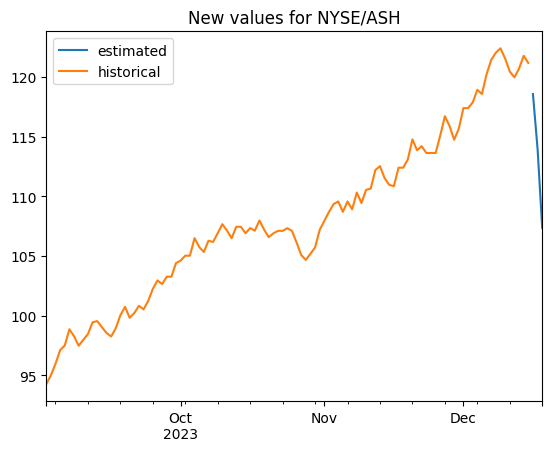

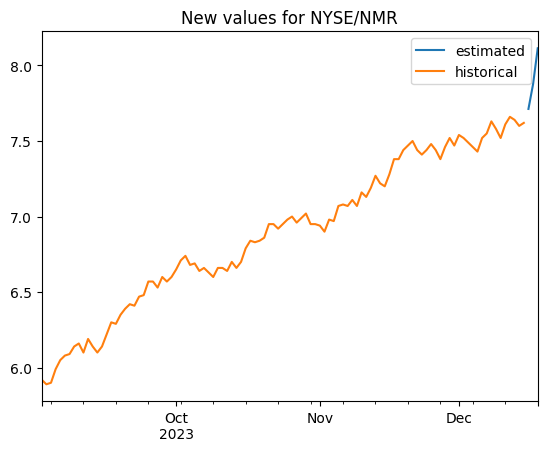

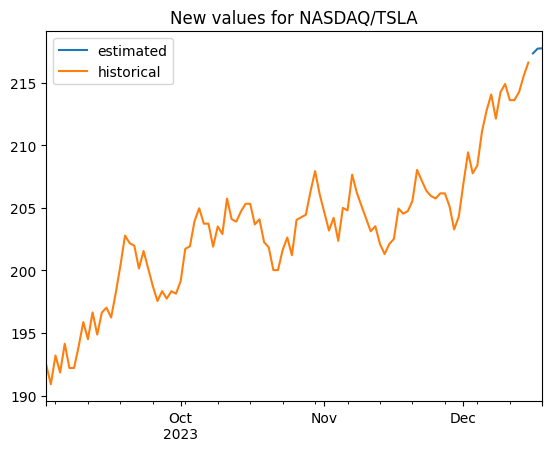

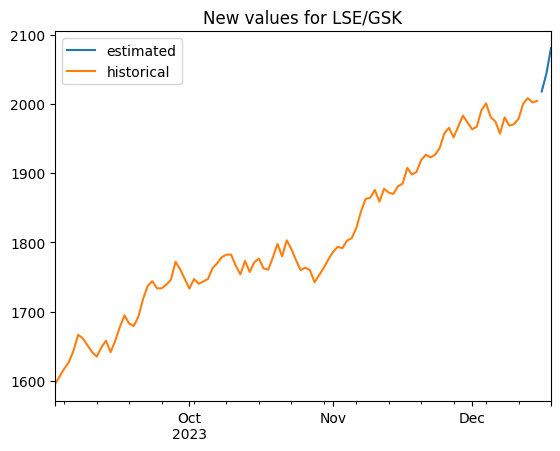

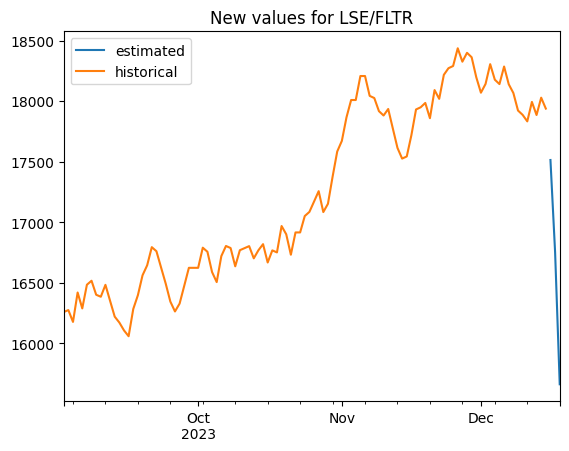

In [169]:
for exchange in all_exchanges:
    for stock in all_stocks:
        import datetime
        if not f"{exchange}/{stock}.csv"in all_input_files:
            continue
        data=[it for it in all_input_files[f"{exchange}/{stock}.csv"].values]
        dates=[datetime.datetime.strptime(it[1],'%d-%m-%Y')for it in data]
        prices=[it[2]for it in data]
        df=pandas.DataFrame(prices,dates)
        #df.plot(title=f"Historical values for {exchange}/{stock}")
        
        max_date=max(dates)
        all_dates=[*dates,*[max_date+datetime.timedelta(days=it) for it in range(1,4)]]
        series=pandas.Series([*prices,*[numpy.NaN for it in range(1,4)]],index=all_dates)
        kw = dict(method="quadratic", fill_value="extrapolate", limit_direction="both")
        all_prices=[*series.interpolate(**kw).values]
        
        old_prices=[*prices,*[numpy.NaN for it in range(1,4)]]
        new_prices=[*[numpy.NaN for it in prices],*all_prices[-3:]]
        agg=zip(old_prices,new_prices)
        df=pandas.DataFrame([{'historical':it[0],'estimated':it[1]}for it in agg],index=all_dates)
        df.plot(y=['estimated','historical'],title=f"New values for {exchange}/{stock}")
        
        output_data=[[stock,it[0],it[1][1]]for it in [*zip(all_dates,df.values)][-3:]]
        
        print(output_data)
        output_path=pathlib.Path('..','output',f'{exchange}_{stock}.out.csv').absolute()
        with open(output_path,'tw')as output_file:
            pandas.DataFrame(output_data).to_csv(output_file,date_format="%m-%d-%Y",index=False,header=False,lineterminator='\n')